データについて
- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv - supplemental information about the shops.

データ項目について
- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

参考
- https://www.kaggle.com/dlarionov/feature-engineering-xgboost
- https://www.kaggle.com/kawakeee/feature-engineering-xgboost/data
- https://yolo-kiyoshi.com/2019/03/23/post-1090/
- 5060_tsa

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
# データの読み込み
train = pd.read_csv('./competitive-data-science-predict-future-sales/sales_train.csv')
test = pd.read_csv('./competitive-data-science-predict-future-sales/test.csv')
cats = pd.read_csv('./competitive-data-science-predict-future-sales/item_categories.csv')
items = pd.read_csv('./competitive-data-science-predict-future-sales/items.csv')
shops = pd.read_csv('./competitive-data-science-predict-future-sales/shops.csv')


In [3]:
# データサイズの確認
print(train.shape)
print(test.shape)

(2935849, 6)
(214200, 3)


In [4]:
train
# trainには、2013年1月〜2015年10月の34か月分のデータが入ってる

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [5]:
test.head()
# 2015年11月のshop_id, item_idごとのsalesを予測する

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


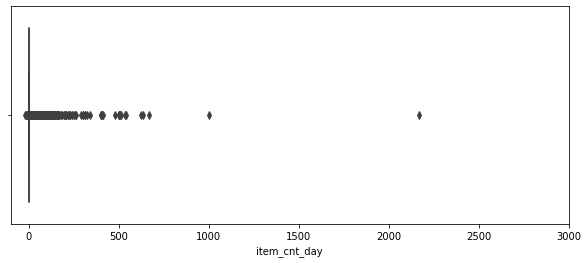

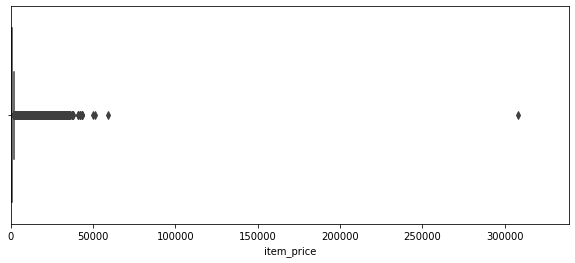

In [6]:
# 箱ひげ図でitem_price, item_cnt_dayの外れ値の確認

plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)


In [7]:
# 各データに存在している外れ値の削除。
train = train[train.item_price <= 100000]
train = train[train.item_cnt_day <= 1000]

In [8]:
# 誤って登録されたデータの確認・修正

# item_priceが0以下の値
train[train.item_price <= 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [9]:
# 同じ年月・店・商品IDの中央値を代入する。

med = train.loc[(train.date_block_num == 4) & 
            (train.shop_id == 32) & (train.item_id == 2973) & 
            (train.item_price > 0), 'item_price'].median()

train.loc[train.item_price < 0, 'item_price'] = med

train[train.item_price <= 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


In [10]:
# shopsの前処理
print(shops.shape)
shops

# 60店舗
# shop_nameは'ヤクーツクOrdzhonikidze、56'のように'都市名 店名？'のようになっている。
# 重複の都市がある様子。


(60, 2)


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [11]:
# 重複している店名のIDを統一する

# 'Якутск Орджоникидзе, 56
# 'Якутск Орджоникидзе, 56 фран	
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

# !Якутск ТЦ "Центральный" фран	
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

# Жуковский ул. Чкалова 39м?
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11


# 3shops重複があるので57店舗になる。

In [12]:
# 重複があり不要になった列を削除
shops = shops.drop([0, 1, 10])

In [13]:
# shopsは、都市名から始まっているようなので、都市名を抜き出す。
shops['city'] = shops['shop_name'].map(lambda x: x.split(' ')[0])
shops['city'].value_counts()

Москва              13
Воронеж              3
РостовНаДону         3
Тюмень               3
Якутск               2
Красноярск           2
Самара               2
СПб                  2
Уфа                  2
Н.Новгород           2
Казань               2
Новосибирск          2
Чехов                1
Калуга               1
Интернет-магазин     1
Балашиха             1
Ярославль            1
Адыгея               1
Сергиев              1
Коломна              1
Выездная             1
Жуковский            1
Сургут               1
Химки                1
Вологда              1
Курск                1
Волжский             1
Мытищи               1
Томск                1
Омск                 1
Цифровой             1
Name: city, dtype: int64

In [14]:
# 都市名を数値化
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
#shops = shops[['shop_id', 'city_code']]

shops # 31都市に分類された

,shop_name,shop_id,city,city_code
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,1
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,2
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,3
6,"Воронеж (Плехановская, 13)",6,Воронеж,4
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,4
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,4
9,Выездная Торговля,9,Выездная,5
11,Жуковский ул. Чкалова 39м²,11,Жуковский,6
12,Интернет-магазин ЧС,12,Интернет-магазин,7


In [15]:
# どうせ読めないしshop_nameとcityはdrop
shops = shops.drop(['shop_name', 'city'], axis=1)
shops.head()

,shop_id,city_code
2,2,0
3,3,1
4,4,2
5,5,3
6,6,4


In [16]:
# catsの確認
print(cats.shape)
cats

# item_category_nameは'大分類 - 小分類'になってる
#小分類のないものもある
# ()は個とかっぽい
# Чистые носители (штучные)	
# ↑ブランクメディア（個）

(84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [17]:
# 大分類、小分類をわける
cats['split'] = cats['item_category_name'].str.split(' - ')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() 
                                    if len(x) > 1 else x[0].strip())

# type, subtypeを数値化
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])

cats

,item_category_name,item_category_id,split,type,subtype,type_code,subtype_code
0,PC - Гарнитуры/Наушники,0,"[PC, Гарнитуры/Наушники]",PC,Гарнитуры/Наушники,0,31
1,Аксессуары - PS2,1,"[Аксессуары, PS2]",Аксессуары,PS2,1,11
2,Аксессуары - PS3,2,"[Аксессуары, PS3]",Аксессуары,PS3,1,12
3,Аксессуары - PS4,3,"[Аксессуары, PS4]",Аксессуары,PS4,1,13
4,Аксессуары - PSP,4,"[Аксессуары, PSP]",Аксессуары,PSP,1,15
...,...,...,...,...,...,...,...
79,Служебные,79,[Служебные],Служебные,Служебные,16,56
80,Служебные - Билеты,80,"[Служебные, Билеты]",Служебные,Билеты,16,27
81,Чистые носители (шпиль),81,[Чистые носители (шпиль)],Чистые носители (шпиль),Чистые носители (шпиль),17,64
82,Чистые носители (штучные),82,[Чистые носители (штучные)],Чистые носители (штучные),Чистые носители (штучные),18,65


In [18]:
# 不要な列の削除
cats = cats.drop(['item_category_name', 'split', 'type', 'subtype'], axis=1)

In [19]:
cats.head()

,item_category_id,type_code,subtype_code
0,0,0,31
1,1,1,11
2,2,1,12
3,3,1,13
4,4,1,15


In [20]:
# itemsの確認
print(items.shape)
items

# item_category_nameは'大分類 - 小分類'になってる
#小分類のないものもある
# ()は個とかっぽい
# Чистые носители (штучные)	
# ↑ブランクメディア（個）

# itemsはすでに、カテゴリー分けされた列があるので、そのまま使う

items = items.drop(['item_name'], axis=1)
items.head()

(22170, 3)


,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


In [21]:
# データの確認

# test(item_id) - (test(item_id) 積集合 train(item_id)) = trainに存在しないtestの商品IDの数
# https://pg-chain.com/python-intersectiion
print(len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))))
# testの商品IDの数(重複は除く)
print(len(list(set(test.item_id))))
# testの総数
print(len(test))


363
5100
214200


In [22]:
# 売り上げデータの作成
train['daily_sales'] = train['item_price'] * train['item_cnt_day']
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,daily_sales
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00


In [23]:
from itertools import product
# 複数のリストの直積（デカルト積）を生成するためのライブラリ
# https://note.nkmk.me/python-itertools-product/

# trainに存在するdate_block_num, shop_id, item_idの全組み合わせを列挙した行列を生成
# 最終的にmatrixを学習モデルのトレーニングデータとする。

matrix = []
for i in range(34):
    sales = train[train.date_block_num == i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))

matrix

[array([[    0,    59, 22154],
        [    0,    59,  2552],
        [    0,    59,  2554],
        ...,
        [    0,    45,   628],
        [    0,    45,   631],
        [    0,    45,   621]], dtype=int16),
 array([[    1,    50,  3880],
        [    1,    50,  4128],
        [    1,    50,  4124],
        ...,
        [    1,    28, 12885],
        [    1,    28, 12791],
        [    1,    28, 13433]], dtype=int16),
 array([[    2,     5, 20175],
        [    2,     5, 20083],
        [    2,     5,    31],
        ...,
        [    2,     4, 12388],
        [    2,     4, 12340],
        [    2,     4, 10649]], dtype=int16),
 array([[    3,    25,  8092],
        [    3,    25,  7850],
        [    3,    25,  8051],
        ...,
        [    3,    41, 14063],
        [    3,    41, 20690],
        [    3,    41, 19235]], dtype=int16),
 array([[    4,    59, 22114],
        [    4,    59, 20239],
        [    4,    59, 20238],
        ...,
        [    4,     6,  1924],
       

In [24]:
# データフレームに直す
cols = ['date_block_num', 'shop_id', 'item_id']
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
# ↓np.vstackについて
# https://www.sejuku.net/blog/72890
matrix


,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564
...,...,...,...
10913799,33,21,7635
10913800,33,21,7638
10913801,33,21,7640
10913802,33,21,7632


In [25]:
matrix.sort_values(cols, inplace=True)
matrix.head()

,date_block_num,shop_id,item_id
114910,0,2,19
117150,0,2,27
120623,0,2,28
118316,0,2,29
114602,0,2,32


In [26]:
matrix.shape

(10913804, 3)

In [27]:
train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'daily_sales'],
      dtype='object')

In [28]:
# 月次の店舗別・商品別の売上数を抜き出す

group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
# どちらも同じ。上記の方が短く書ける。
# [['date_block_num','shop_id','item_id',]]を省略できる。便利。
# group = train[['date_block_num','shop_id','item_id', 'item_cnt_day']].groupby(['date_block_num', 'shop_id', 'item_id']).sum()

# 列名を更新
group.columns = ['item_cnt_month']

# DataFrameGroupBy -> DataFrame に変換
group.reset_index(inplace=True)
# このとき、group = を付けると更新がうまくいかなくて、返り値がNoneになるから注意！
# https://note.nkmk.me/python-pandas-dataframe-rename/

group.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0


In [29]:
# groupをmatrixに結合
matrix = pd.merge(matrix, group, on=cols, how='left')
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,NaN
1,0,2,27,1.0
2,0,2,28,NaN
3,0,2,29,NaN
4,0,2,32,NaN


In [30]:
# 同じものをdaily_salesでもつくる
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'daily_sales': ['sum']})

# 列名を更新
group.columns = ['monthly_sales']

# DataFrameGroupBy -> DataFrame に変換
group.reset_index(inplace=True)

# groupをmatrixに結合
matrix = pd.merge(matrix, group, on=cols, how='left')
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,monthly_sales
0,0,2,19,NaN,NaN
1,0,2,27,1.0,2499.0
2,0,2,28,NaN,NaN
3,0,2,29,NaN,NaN
4,0,2,32,NaN,NaN


In [31]:
matrix.shape

(10913804, 5)

In [32]:
# testの前処理

# 2015年11月のデータのため、date_block_num=34に設定
test['date_block_num'] = 34

test.head()

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


In [33]:
test.shape

(214200, 4)

In [34]:
# matrixにtestを連結させる

matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,monthly_sales,ID
0,0,2,19,NaN,NaN,NaN
1,0,2,27,1.0,2499.0,NaN
2,0,2,28,NaN,NaN,NaN
3,0,2,29,NaN,NaN,NaN
4,0,2,32,NaN,NaN,NaN
...,...,...,...,...,...,...
11127999,34,45,18454,NaN,NaN,214195.0
11128000,34,45,16188,NaN,NaN,214196.0
11128001,34,45,15757,NaN,NaN,214197.0
11128002,34,45,19648,NaN,NaN,214198.0


In [35]:
# NaNを0に変換
matrix.fillna(0, inplace=True)
matrix[matrix.date_block_num==34]

,date_block_num,shop_id,item_id,item_cnt_month,monthly_sales,ID
10913804,34,5,5037,0.0,0.0,0.0
10913805,34,5,5320,0.0,0.0,1.0
10913806,34,5,5233,0.0,0.0,2.0
10913807,34,5,5232,0.0,0.0,3.0
10913808,34,5,5268,0.0,0.0,4.0
...,...,...,...,...,...,...
11127999,34,45,18454,0.0,0.0,214195.0
11128000,34,45,16188,0.0,0.0,214196.0
11128001,34,45,15757,0.0,0.0,214197.0
11128002,34,45,19648,0.0,0.0,214198.0


In [36]:
# shops, cats, itemsの特徴量を追加

matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')

matrix

,date_block_num,shop_id,item_id,item_cnt_month,monthly_sales,ID,city_code,item_category_id,type_code,subtype_code
0,0,2,19,0.0,0.0,0.0,0,40,11,6
1,0,2,27,1.0,2499.0,0.0,0,19,5,12
2,0,2,28,0.0,0.0,0.0,0,30,8,57
3,0,2,29,0.0,0.0,0.0,0,23,5,18
4,0,2,32,0.0,0.0,0.0,0,40,11,6
...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,0.0,214195.0,20,55,13,4
11128000,34,45,16188,0.0,0.0,214196.0,20,64,14,44
11128001,34,45,15757,0.0,0.0,214197.0,20,55,13,4
11128002,34,45,19648,0.0,0.0,214198.0,20,40,11,6


Text(0.5, 1.0, 'Montly item counts of Company')

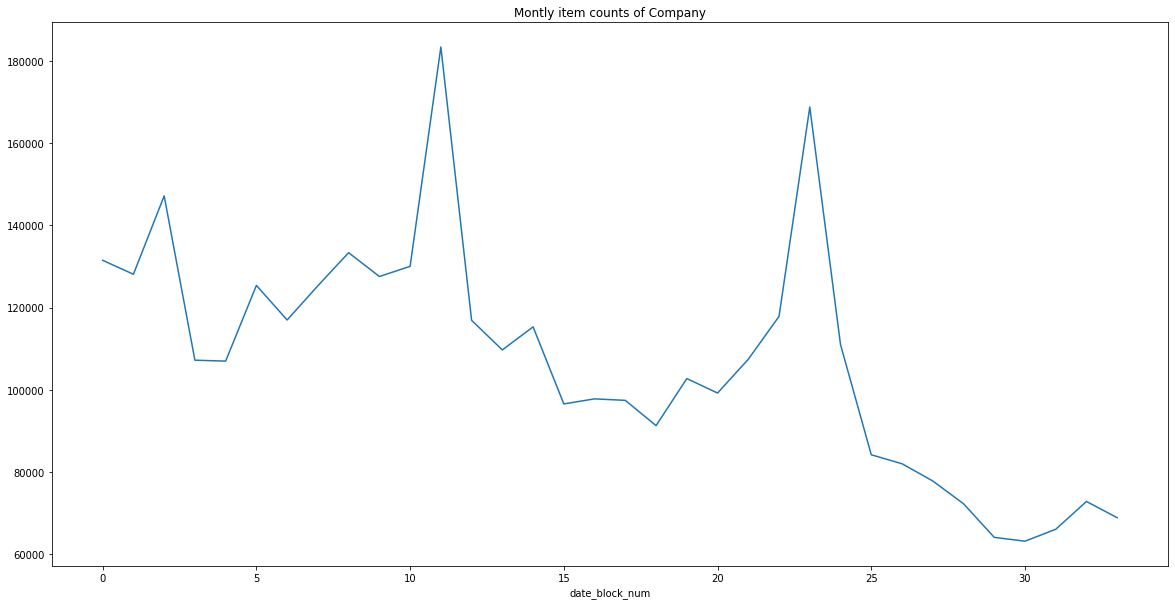

In [37]:
# データの可視化
plt_df = matrix[matrix['date_block_num'] < 34].groupby(['date_block_num'])['item_cnt_month'].sum()
plt.figure(figsize=(20, 10))
plt_df.plot()
plt.title('Montly item counts of Company')


Text(0.5, 1.0, 'Montly item counts by type')

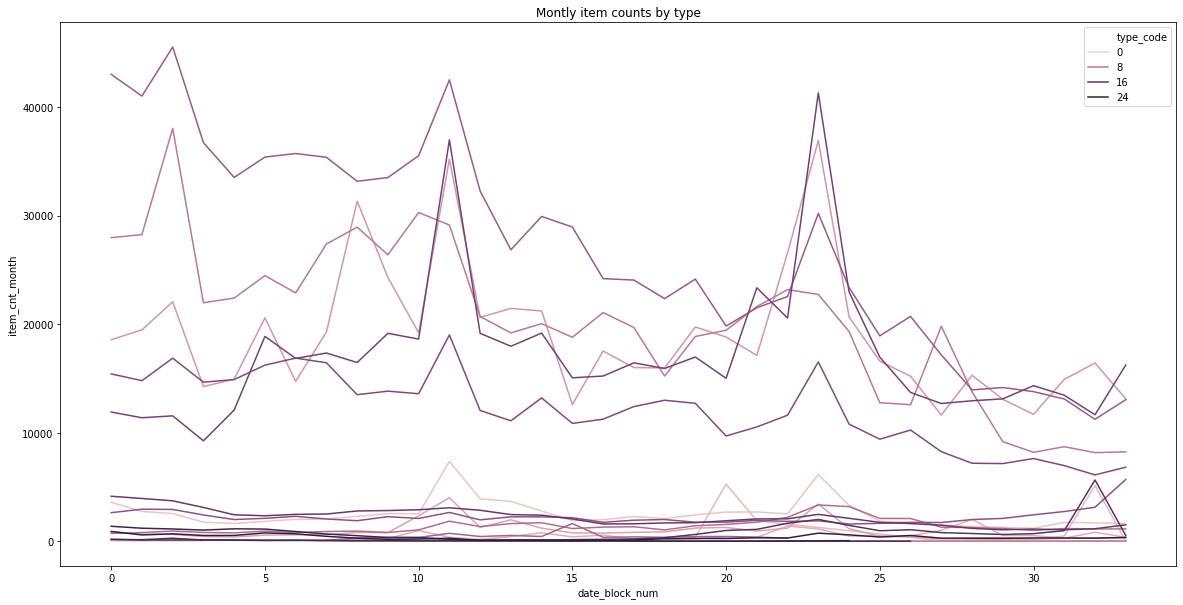

In [38]:
# セグメント別の月次商品売り上げ数
plt_df = matrix[matrix['date_block_num'] < 34].groupby(['date_block_num', 'type_code'], as_index=False).sum()
plt.figure(figsize=(20, 10))
sns.lineplot(x='date_block_num', y='item_cnt_month', data=plt_df, hue='type_code')
plt.title('Montly item counts by type')


Text(0.5, 1.0, 'Montly item counts by type')

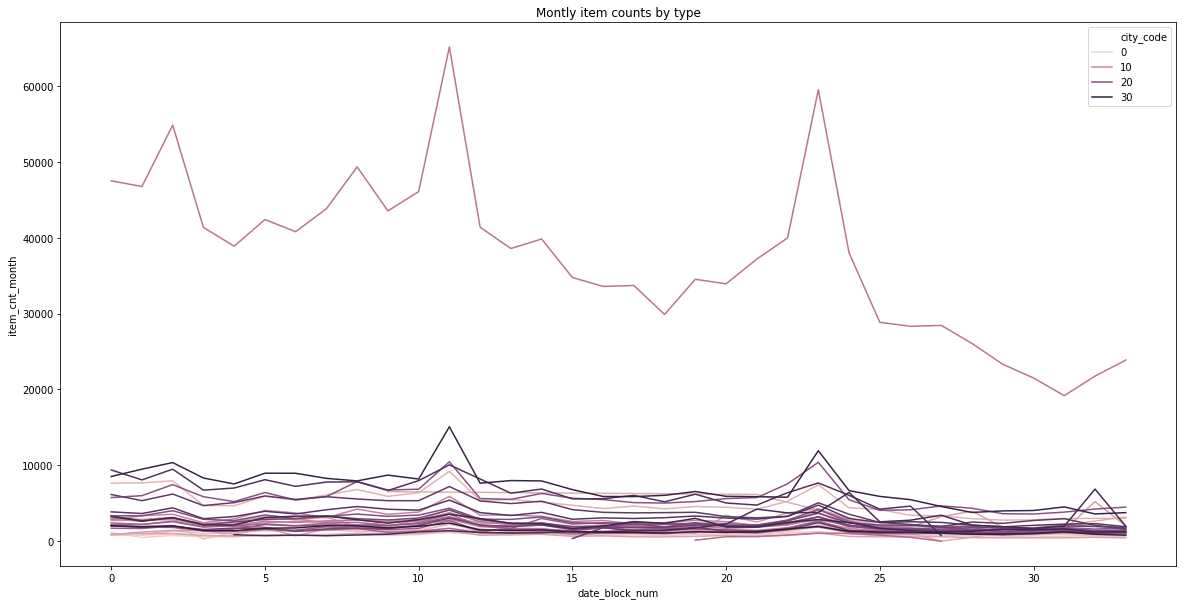

In [39]:
# 都市別の月次商品売り上げ数
plt_df = matrix[matrix['date_block_num'] < 34].groupby(['date_block_num', 'city_code'], as_index=False).sum()
plt.figure(figsize=(20, 10))
sns.lineplot(x='date_block_num', y='item_cnt_month', data=plt_df, hue='city_code')
plt.title('Montly item counts by type')


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """


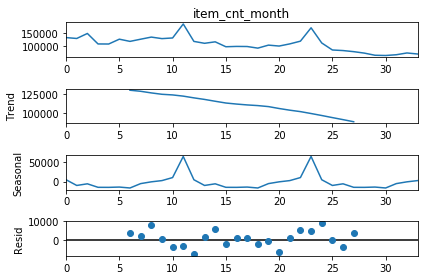

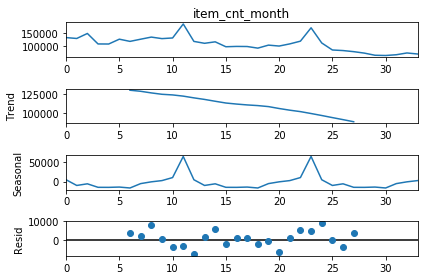

In [40]:
import statsmodels.api as sm
plt_df = matrix[matrix['date_block_num'] < 34].groupby(['date_block_num'])['item_cnt_month'].sum()

# 「データを季節調整してトレンドを調べる」
sm.tsa.seasonal_decompose(plt_df, freq=12).plot()

In [41]:
# 売上数には周期性がみられるので、ラグ特徴量を生成する
# その前に、月次売上数を0~20の範囲に修正する。
# KaggleのOverview>Evacuationより下記の記載あり
# "True target values are clipped into [0,20] range."

matrix['item_cnt_month'] = matrix['item_cnt_month'].clip(0, 20)
# np.clipについて
# https://note.nkmk.me/python-numpy-clip/

matrix.describe()


,date_block_num,shop_id,item_id,item_cnt_month,monthly_sales,ID,city_code,item_category_id,type_code,subtype_code
count,1.112800e+07,1.112800e+07,1.112800e+07,1.112800e+07,1.112800e+07,1.112800e+07,1.112800e+07,1.112800e+07,1.112800e+07,1.112800e+07
mean,1.533960e+01,3.138372e+01,1.130371e+04,2.925003e-01,3.054113e+02,2.061530e+03,1.530356e+01,4.494398e+01,1.107023e+01,1.987040e+01
std,9.760412e+00,1.730666e+01,6.210934e+03,1.211247e+00,5.870769e+03,1.703338e+04,8.018806e+00,1.514000e+01,2.854886e+00,2.036442e+01
min,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,-3.378700e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.000000e+00,1.600000e+01,5.947000e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01,3.700000e+01,1.100000e+01,4.000000e+00
50%,1.500000e+01,3.100000e+01,1.138800e+04,0.000000e+00,0.000000e+00,0.000000e+00,1.300000e+01,4.000000e+01,1.100000e+01,6.000000e+00
75%,2.300000e+01,4.700000e+01,1.659200e+04,0.000000e+00,0.000000e+00,0.000000e+00,2.200000e+01,5.500000e+01,1.300000e+01,3.400000e+01
max,3.400000e+01,5.900000e+01,2.216900e+04,2.000000e+01,6.264230e+06,2.141990e+05,3.000000e+01,8.300000e+01,1.900000e+01,6.600000e+01


In [42]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num', 'shop_id', 'item_id', col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num', 'shop_id', 'item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    return df

In [43]:
matrix = lag_feature(matrix, [1, 2, 3, 6, 12], 'item_cnt_month')
matrix

,date_block_num,shop_id,item_id,item_cnt_month,monthly_sales,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,2,19,0.0,0.0,0.0,0,40,11,6,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,2499.0,0.0,0,19,5,12,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0.0,0.0,0,30,8,57,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0.0,0.0,0,23,5,18,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0.0,0.0,0,40,11,6,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,0.0,214195.0,20,55,13,4,1.0,0.0,0.0,0.0,NaN
11128000,34,45,16188,0.0,0.0,214196.0,20,64,14,44,0.0,0.0,NaN,NaN,NaN
11128001,34,45,15757,0.0,0.0,214197.0,20,55,13,4,0.0,0.0,0.0,0.0,0.0
11128002,34,45,19648,0.0,0.0,214198.0,20,40,11,6,0.0,0.0,0.0,0.0,NaN


In [44]:
matrix = matrix.fillna(0)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,monthly_sales,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,2,19,0.0,0.0,0.0,0,40,11,6,0.0,0.0,0.0,0.0,0.0
1,0,2,27,1.0,2499.0,0.0,0,19,5,12,0.0,0.0,0.0,0.0,0.0
2,0,2,28,0.0,0.0,0.0,0,30,8,57,0.0,0.0,0.0,0.0,0.0
3,0,2,29,0.0,0.0,0.0,0,23,5,18,0.0,0.0,0.0,0.0,0.0
4,0,2,32,0.0,0.0,0.0,0,40,11,6,0.0,0.0,0.0,0.0,0.0


In [104]:
# トレーニングデータ
# X_train = matrix[matrix['date_block_num']<33].drop(['item_cnt_month'], axis=1)
# Y_train = matrix[matrix['date_block_num']<33]['item_cnt_month']

# バリデーション用データ
# X_valid = matrix[matrix['date_block_num']==33].drop(['item_cnt_month'], axis=1)
# Y_valid = matrix[matrix['date_block_num']==33]['item_cnt_month']

# テスト用データ
# X_test = matrix[matrix['date_block_num']==34].drop(['item_cnt_month'], axis=1)


In [105]:
# from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

# names = ['線形回帰', 'ラッソ回帰', 'リッジ回帰', 'ElasticNet', 'ランダムフォレスト']
# models = [LinearRegression(), Lasso(), Ridge(), ElasticNet(), RandomForestRegressor()]

# max_score = 0
# best_model = 0

# for name, model in zip(names, models):
#     model.fit(X_train, Y_train)
#     score = model.score(X_valid, Y_valid)
#     print("{}: {}".format(model, score))
#     if score > best_model:
#         best_model = score
#         best_model_name = name
# print()
# print("ベストモデル: {}".format(best_model_name))
# print("ベストスコア: {}".format(best_model))

In [47]:
# トレーニングデータ
X_train = matrix[(matrix['date_block_num']>=12) & (matrix['date_block_num']<33)].drop(['item_cnt_month'], axis=1)
Y_train = matrix[(matrix['date_block_num']>=12) & (matrix['date_block_num']<33)]['item_cnt_month']

# バリデーション用データ
X_valid = matrix[matrix['date_block_num']==33].drop(['item_cnt_month'], axis=1)
Y_valid = matrix[matrix['date_block_num']==33]['item_cnt_month']

# テスト用データ
X_test = matrix[matrix['date_block_num']==34].drop(['item_cnt_month'], axis=1)


In [48]:
# from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

names = ['線形回帰', 'ラッソ回帰', 'リッジ回帰', 'ElasticNet', 'ランダムフォレスト']
models = [LinearRegression(), Lasso(), Ridge(), ElasticNet(), RandomForestRegressor()]

max_score = 0
best_model = 0

for name, model in zip(names, models):
    model.fit(X_train, Y_train)
    score = model.score(X_valid, Y_valid)
    print("{}: {}".format(model, score))
    if score > best_model:
        best_model = score
        best_model_name = name
print()
print("ベストモデル: {}".format(best_model_name))
print("ベストスコア: {}".format(best_model))

LinearRegression(): 0.3871432880155239
Lasso(): 0.21152433494201173
Ridge(): 0.38714329589924446
ElasticNet(): 0.28640005121357226
RandomForestRegressor(): 0.8996398385103794

ベストモデル: ランダムフォレスト
ベストスコア: 0.8996398385103794


In [49]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier

names = ['ナイーブベイズ', 'パーセプトロン', '確率的勾配降下法']
models = [GaussianNB(), Perceptron(), SGDClassifier()]

max_score = 0
best_model = 0

for name, model in zip(names, models):
    model.fit(X_train, Y_train)
    score = model.score(X_valid, Y_valid)
    print("{}: {}".format(model, score))
    if score > best_model:
        best_model = score
        best_model_name = name
print()
print("ベストモデル: {}".format(best_model_name))
print("ベストスコア: {}".format(best_model))

GaussianNB(): 0.9238365550946375
Perceptron(): 0.869967922341837
SGDClassifier(): 0.956585996674672

ベストモデル: 確率的勾配降下法
ベストスコア: 0.956585996674672


In [50]:
# 確率的勾配降下法の適用
model = SGDClassifier()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

In [51]:
Y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [56]:
submission_sgd = pd.DataFrame({
    'ID': test['ID'],
    'item_cnt_month': Y_pred
})

submission_sgd.to_csv('./competitive-data-science-predict-future-sales/submission_sgd.csv', index=False)

submission_sgd

,ID,item_cnt_month
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
...,...,...
214195,214195,0.0
214196,214196,0.0
214197,214197,0.0
214198,214198,0.0


In [57]:
submission_sgd.head(50)

,ID,item_cnt_month
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
5,5,0.0
6,6,0.0
7,7,0.0
8,8,0.0
9,9,0.0
